# Introduction

In this notebook, I shall conduct a very basic attempt at topic modelling this Spooky Author dataset. Topic modelling is the process in which we try uncover abstract themes or "topics" based on the underlying documents and words in a corpus of text. I will introduce two standard topic modelling techniques here with the first technique known as Latent Dirichlet Allocation (LDA) and the second Non-negative Matrix Factorization (NMF). I will also take the opportunity to introduce some Natural Language Processing basics such as Tokenization, Stemming and vectorization of the raw text which should also hopefully come in handy when making predictions with learning models. 

The outline of this notebook is as follows:

1. **Exploratory Data Analysis (EDA) and Wordclouds** - Analyzing the data by generating simple statistics such word frequencies over the different authors as well as plotting some wordclouds (with image masks).


2. **Natural Language Processing (NLP) with NLTK (Natural Language Toolkit) ** - Introducing basic text processing methods such as tokenizations, stop word removal, stemming and vectorizing text via term frequencies (TF) as well as the inverse document frequencies (TF-IDF)

3. **Topic Modelling with LDA and NNMF** - Implementing the two topic modelling techniques of Latent Dirichlet Allocation (LDA) and Non-negative Matrix Factorization (NMF).


# 設定Colab and plotly 


In [14]:
## colab load, turn into Kaggle work diretory
from google.colab import drive
import os
drive.mount("/content/drive")
os.chdir("/content/drive/My Drive/Kaggle/spooky-nlp-and-topic-modelling-tutorial") #更改路徑
os.getcwd() #查看當前路徑

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


'/content/drive/My Drive/Kaggle/spooky-nlp-and-topic-modelling-tutorial'

In [18]:
os.getcwd() #查看當前路徑

'/content/drive/My Drive/Kaggle/spooky-nlp-and-topic-modelling-tutorial'

In [27]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))

In [9]:
import base64
import numpy as np
import pandas as pd
# Plotly imports
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

# Other imports
from collections import Counter
# from scipy.misc import imread
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from matplotlib import pyplot as plt
%matplotlib inline

In [19]:
# Loading in the training data with Pandas
train = pd.read_csv("./input/train/train.csv")

---

# 1. The Authors and their works EDA

First step, let us take a look at a quick peek of what the first three rows in the data has in store for us and who exactly are the authors

In [20]:
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


According to the competition page there are three distinct author initials we have already been provided with a mapping of these initials to the actual author which is as follows:

*(Links to their Wikipedia page profiles if you click on their names)*

1. **[EAP - Edgar Allen Poe](https://en.wikipedia.org/wiki/Edgar_Allan_Poe)** : American writer who wrote poetry and short stories that revolved around tales of mystery and the grisly and the grim. Arguably his most famous work is the poem - "The Raven" and he is also widely considered the pioneer of the genre of the detective fiction. 

2. **[HPL - HP Lovecraft](https://en.wikipedia.org/wiki/H._P._Lovecraft)** : Best known for authoring works of horror fiction, the stories that he is most celebrated for revolve around the fictional mythology of the infamous creature "Cthulhu" - a hybrid chimera mix of Octopus head and humanoid body with wings on the back.

3. **[MWS - Mary Shelley](https://en.wikipedia.org/wiki/Mary_Shelley)** : Seemed to have been involved in a whole panoply of literary pursuits - novelist, dramatist, travel-writer, biographer. She is most celebrated for the classic tale of Frankenstein where the scientist Frankenstein a.k.a "The Modern Prometheus" creates the Monster that comes to be associated with his name.

Next, let us take a look at how large the training data is:

In [21]:
print(train.shape)

(19579, 3)


## Summary statistics of the training set


In [28]:
configure_plotly_browser_state()
z = {'EAP': 'Edgar Allen Poe', 'MWS': 'Mary Shelley', 'HPL': 'HP Lovecraft'}
data = [go.Bar(
            x = train.author.map(z).unique(),
            y = train.author.value_counts().values,
            marker= dict(colorscale='Jet',
                         color = train.author.value_counts().values
                        ),
            text='Text entries attributed to Author'
    )]

layout = go.Layout(
    title='Target variable distribution'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

In [30]:
configure_plotly_browser_state()
all_words = train['text'].str.split(expand=True).unstack().value_counts()
data = [go.Bar(
            x = all_words.index.values[2:50],
            y = all_words.values[2:50],
            marker= dict(colorscale='Jet',
                         color = all_words.values[2:100]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 (Uncleaned) Word frequencies in the training dataset'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

---

# 2. Natural Language Processing

![](https://s-media-cache-ak0.pinimg.com/originals/d8/ca/04/d8ca049fd1ad2d92818763e55c57f49a.jpg)

In almost all Natural Language Processing (the field that explores interactions between a computer and human languages) tasks that you will come across (be it topic modelling, or word clustering or document-text classification etc), one will generally always have to undergo these few pre-processing steps to convert the input raw text into a form that is readable by your model and the machine. You certainly can't expect to feed a Random Forest model a paragraph of words and expect it to immediately predict which author that paragraph came from. Behind the scenes, text pre-processing can be boiled down to these few simple steps:

1. **Tokenization** - Segregation of the text into its individual constitutent words. 
2. **Stopwords** - Throw away any words that occur too frequently as its frequency of occurrence will not be useful in helping detecting relevant texts. (as an aside also consider throwing away words that occur very infrequently).
3. **Stemming**  - combine variants of words into a single parent word that still conveys the same meaning
4. **Vectorization** - Converting text into vector format. One of the simplest is the famous bag-of-words approach, where you create a matrix (for each document or text in the corpus). In the simplest form, this matrix stores word frequencies (word counts) and is oft referred to as vectorization of the raw text. 

**Natural Language Toolkit (NLTK)**: To make our Natural Language Processing endeavours more convenient, let me introduce to you one of the most handy toolkits that on NLP - the Natural Language Toolkit, also more commonly referred to as the  [NLTK](http://www.nltk.org/) module. To import the toolkit, it is as easier as:



In [38]:
import nltk

In [39]:
# Storing the first text element as a string
first_text = train.text.values[0]
print(first_text)
print("="*90)
print(first_text.split(" "))

This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
['This', 'process,', 'however,', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon;', 'as', 'I', 'might', 'make', 'its', 'circuit,', 'and', 'return', 'to', 'the', 'point', 'whence', 'I', 'set', 'out,', 'without', 'being', 'aware', 'of', 'the', 'fact;', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall.']


In [43]:
nltk.download('punkt')
first_text_list = nltk.word_tokenize(first_text)

print(first_text_list)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
['This', 'process', ',', 'however', ',', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon', ';', 'as', 'I', 'might', 'make', 'its', 'circuit', ',', 'and', 'return', 'to', 'the', 'point', 'whence', 'I', 'set', 'out', ',', 'without', 'being', 'aware', 'of', 'the', 'fact', ';', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall', '.']


## 2b. Stopword Removal



In [45]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
len(stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


179

In [46]:
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

To filter out stop words from our tokenized list of words, we can simply use a list comprehension as follows:

In [47]:
first_text_list_cleaned = [word for word in first_text_list if word.lower() not in stopwords]
print(first_text_list_cleaned)
print("="*90)
print("Length of original list: {0} words\n"
      "Length of list after stopwords removal: {1} words"
      .format(len(first_text_list), len(first_text_list_cleaned)))

['process', ',', 'however', ',', 'afforded', 'means', 'ascertaining', 'dimensions', 'dungeon', ';', 'might', 'make', 'circuit', ',', 'return', 'point', 'whence', 'set', ',', 'without', 'aware', 'fact', ';', 'perfectly', 'uniform', 'seemed', 'wall', '.']
Length of original list: 48 words
Length of list after stopwords removal: 28 words


As you can see, our list with stopwords removed is now substantially shorter than before where commonly occuring words such as "I", "me", "to" and "the" have been removed.

## 2c. Stemming and Lemmatization


In [49]:
stemmer = nltk.stem.PorterStemmer()

And now we can use stemmer to see if it can reduce our these test words ("running", "runs", "run") into their a single stemmed word. Conveniently we can test the stemmer on the fly as follows:

In [50]:
print("The stemmed form of running is: {}".format(stemmer.stem("running")))
print("The stemmed form of runs is: {}".format(stemmer.stem("runs")))
print("The stemmed form of run is: {}".format(stemmer.stem("run")))

The stemmed form of running is: run
The stemmed form of runs is: run
The stemmed form of run is: run


In [54]:
print("The stemmed form of leaves is: {}".format(stemmer.stem("leaves")))

The stemmed form of leaves is: leav


### Lemmatization to the rescue


In [55]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemm = WordNetLemmatizer()
print("The lemmatized form of leaves is: {}".format(lemm.lemmatize("leaves")))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
The lemmatized form of leaves is: leaf


Brilliant, now we see that our lemmatizer is working and collapsing words into a form that makes much more lexical sense.

## 2d. Vectorizing Raw Text
**The Bag of Words approach**


In [56]:
# Defining our sentence
sentence = ["I love to eat Burgers", 
            "I love to eat Fries"]
vectorizer = CountVectorizer(min_df=0)
sentence_transform = vectorizer.fit_transform(sentence)

**Fitting the vectorizer to the dataset**


In [57]:
print("The features are:\n {}".format(vectorizer.get_feature_names()))
print("\nThe vectorized array looks like:\n {}".format(sentence_transform.toarray()))

The features are:
 ['burgers', 'eat', 'fries', 'love', 'to']

The vectorized array looks like:
 [[1 1 0 1 1]
 [0 1 1 1 1]]


In [58]:
sentence_transform

<2x5 sparse matrix of type '<class 'numpy.int64'>'
	with 8 stored elements in Compressed Sparse Row format>

**Sparse matrix vector ouptuts**


---

# 3. Topic modelling

![](http://tlccentre.ie/wp-content/uploads/2015/10/Halloween1.jpg)

Arriving at our *Final Destination* (pun intended), I will implement two different topic modelling techniques as follows:

1. **Latent Dirichlet Allocation** - Probabilistic, generative model which uncovers the topics latent to a dataset by assigning weights to words in a corpus, where each topic will assign different probability weights to each word. 

2. **Non-negative Matrix Factorization** - Approximation method that takes an input matrix and approximates the factorization of this matrix into two other matrices, with the caveat that the values in the matrix be non-negative.



In [59]:
# Define helper function to print top words
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}:".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

## 3a. Putting all the preprocessing steps together
### Extending the CountVectorizer class with a lemmatizer

In [61]:
lemm = WordNetLemmatizer()
class LemmaCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))

In [62]:
# Storing the entire training text in a list
text = list(train.text.values)
# Calling our overwritten Count vectorizer
tf_vectorizer = LemmaCountVectorizer(max_df=0.95, 
                                     min_df=2,
                                     stop_words='english',
                                     decode_error='ignore')
tf = tf_vectorizer.fit_transform(text)

**Revisiting our Term frequencies**


In [65]:
configure_plotly_browser_state()
feature_names = tf_vectorizer.get_feature_names()
count_vec = np.asarray(tf.sum(axis=0)).ravel()
zipped = list(zip(feature_names, count_vec))
x, y = (list(x) for x in zip(*sorted(zipped, key=lambda x: x[1], reverse=True)))
# Now I want to extract out on the top 15 and bottom 15 words
Y = np.concatenate([y[0:15], y[-16:-1]])
X = np.concatenate([x[0:15], x[-16:-1]])

# Plotting the Plot.ly plot for the Top 50 word frequencies
data = [go.Bar(
            x = x[0:50],
            y = y[0:50],
            marker= dict(colorscale='Jet',
                         color = y[0:50]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 Word frequencies after Preprocessing'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

# Plotting the Plot.ly plot for the Top 50 word frequencies
data = [go.Bar(
            x = x[-100:],
            y = y[-100:],
            marker= dict(colorscale='Portland',
                         color = y[-100:]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Bottom 100 Word frequencies after Preprocessing'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

## 3b. Latent Dirichlet Allocation


**Corpus - Document - Word : Topic Generation**


In [68]:
lda = LatentDirichletAllocation(n_components=11, max_iter=5,
                                learning_method = 'online',
                                learning_offset = 50.,
                                random_state = 0)

In [69]:
##
lda.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=50.0,
                          max_doc_update_iter=100, max_iter=5,
                          mean_change_tol=0.001, n_components=11, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

### Topics generated by LDA


In [70]:
n_top_words = 40
print("\nTopics in LDA model: ")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)


Topics in LDA model: 

Topic #0:mean night fact young return great human looking wonder countenance difficulty greater wife finally set possessed regard struck perceived act society law health key fearful mr exceedingly evidence carried home write lady various recall accident force poet neck conduct investigation

Topic #1:death love raymond hope heart word child went time good man ground evil long misery replied filled passion bed till happiness memory heavy region year escape spirit grief visit doe story beauty die plague making influence thou letter appeared power

Topic #2:left let hand said took say little length body air secret gave right having great arm thousand character minute foot true self gentleman pleasure box clock discovered point sought pain nearly case best mere course manner balloon fear head going

Topic #3:called sense table suddenly sympathy machine sens unusual labour thrown mist solution suppose specie movement whispered urged frequent wine hour appears ring tu

In [71]:
first_topic = lda.components_[0]
second_topic = lda.components_[1]
third_topic = lda.components_[2]
fourth_topic = lda.components_[3]

In [72]:
first_topic.shape

(13781,)

### Word Cloud visualizations of the topics

In [73]:
first_topic_words = [tf_feature_names[i] for i in first_topic.argsort()[:-50 - 1 :-1]]
second_topic_words = [tf_feature_names[i] for i in second_topic.argsort()[:-50 - 1 :-1]]
third_topic_words = [tf_feature_names[i] for i in third_topic.argsort()[:-50 - 1 :-1]]
fourth_topic_words = [tf_feature_names[i] for i in fourth_topic.argsort()[:-50 - 1 :-1]]

### Word cloud of First Topic

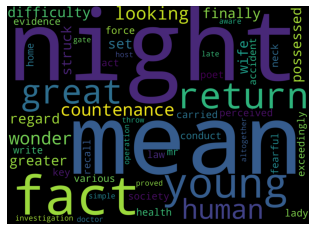

In [74]:
# Generating the wordcloud with the values under the category dataframe
firstcloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(first_topic_words))
plt.imshow(firstcloud)
plt.axis('off')
plt.show()

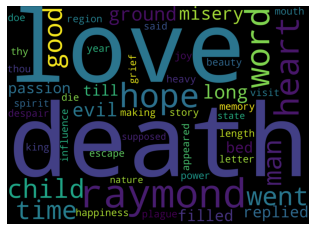

In [75]:
# Generating the wordcloud with the values under the category dataframe
cloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(second_topic_words))
plt.imshow(cloud)
plt.axis('off')
plt.show()

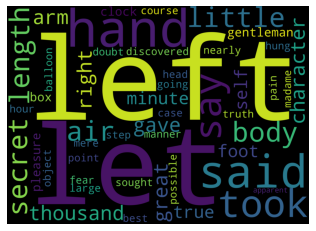

In [76]:
# Generating the wordcloud with the values under the category dataframe
cloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(third_topic_words))
plt.imshow(cloud)
plt.axis('off')
plt.show()

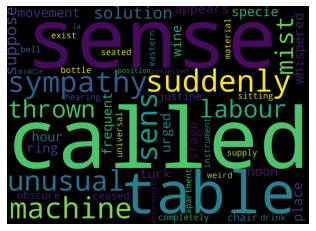

In [77]:
# Generating the wordcloud with the values under the category dataframe
cloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(fourth_topic_words))
plt.imshow(cloud)
plt.axis('off')
plt.show()

# Conclusion